In [48]:
# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import OrderedDict

# Import PyTorch
import torch # import main library
from torch.autograd import Variable
import torch.nn as nn # import modules
from torch.autograd import Function # import Function to create custom activations
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters
from torch import optim # import optimizers for demonstrations
import torch.nn.functional as F # import torch functions
from torchvision import datasets, transforms # import transformations to use for demo
from torch.nn.parameter import Parameter # import Parameter to create custom activations with learnable parameters

from models.activ_func import *
from models.Nets import *
from models.test import test_img
from models.Update import *


from utils.sampling import mnist_iid, mnist_noniid, cifar_iid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, LeNet, CNNMnist2, CNNMnist3
from models.Fed import FedAvg
from models.Fed import FedQAvg, Quantization, Quantization_Finite, my_score, my_score_Finite
from models.test import test_img
from torch.utils.data import DataLoader, Dataset
from utils.functions import *

import torchvision

import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 4  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 1 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [3]:
def validation(model, testloader, criterion):
    test_loss = 0
    accuracy = 0
    for images, labels in testloader:

#         images.resize_(images.shape[0], 3*32*32)

        images = images.cuda()
        labels = labels.cuda()

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return test_loss, accuracy

# 1. Train LeNet with uncoded Dataset

In [28]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

N_epochs = 50

net_glob = CNNCifar(args=args)
net_glob.cuda()

acc_test_FedAvg = np.empty(N_epochs)
loss_test_FedAvg = np.empty(N_epochs)

for iter in range(N_epochs):
    w_locals, loss_locals = [], []

    m = args.num_users
    
    idxs_users = np.random.choice(range(args.num_users), m, replace=False)
    
    for idx in idxs_users:
        local = LocalUpdate(args=args, dataset=dataset_train, idxs=dict_users[idx])
        w, loss = local.train(net=copy.deepcopy(net_glob).to(args.device))
        w_locals.append(copy.deepcopy(w))
        loss_locals.append(copy.deepcopy(loss))
        
    # update global weights
    w_glob = FedAvg(w_locals)

    # copy weight to net_glob
    net_glob.load_state_dict(w_glob)
    
    acc_test, loss_test = test_img(net_glob, dataset_test, args)

    # print loss
    loss_avg = sum(loss_locals) / len(loss_locals)
    print('Round {:3d}, Average loss {:.3f}'.format(iter, loss_avg))
#     loss_train.append(loss_avg)
    
    acc_test_FedAvg[iter] = acc_test
    loss_test_FedAvg[iter] = loss_test


Test set: Average loss: 1.9165 
Accuracy: 3086/10000 (30.86%)

Round   0, Average loss 2.052

Test set: Average loss: 1.7166 
Accuracy: 3844/10000 (38.44%)

Round   1, Average loss 1.866

Test set: Average loss: 1.6110 
Accuracy: 4128/10000 (41.28%)

Round   2, Average loss 1.749

Test set: Average loss: 1.5467 
Accuracy: 4440/10000 (44.40%)

Round   3, Average loss 1.687

Test set: Average loss: 1.4918 
Accuracy: 4617/10000 (46.17%)

Round   4, Average loss 1.633

Test set: Average loss: 1.4462 
Accuracy: 4749/10000 (47.49%)

Round   5, Average loss 1.590

Test set: Average loss: 1.4069 
Accuracy: 4902/10000 (49.02%)

Round   6, Average loss 1.555

Test set: Average loss: 1.3776 
Accuracy: 5043/10000 (50.43%)

Round   7, Average loss 1.525

Test set: Average loss: 1.3544 
Accuracy: 5160/10000 (51.60%)

Round   8, Average loss 1.495

Test set: Average loss: 1.3273 
Accuracy: 5259/10000 (52.59%)

Round   9, Average loss 1.472

Test set: Average loss: 1.3180 
Accuracy: 5321/10000 (53.21

# 2. BACC without grouping

# 2.1. K=2

In [66]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 2  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 5 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [67]:
encoding_input_array_np = np.empty((len(dataset_train),32*32*3))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(50000/args.num_users)


for i in range(args.num_users):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        
#         print(np.size(images_np))
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,32*32*3))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np
    
print(np.shape(encoding_label_array_np))

size of X: (50000, 3072)
size of Y: (50000, 10)
(50000, 10)


In [ ]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 2
T = 3
sigma = 1
Noise_Alloc = [0,2,4]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2]
B_array = [0.5]

N_trials = 1
N_epochs = 50

lr_array = [0.0001] # 0.001 is the bset

sigma_array = [1]
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]


loss_test_arr_K4_G1_v3 = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K4_G1_v3  = np.zeros((len(sigma_array),len(lr_array),N_trials,N_epochs))

N = 2
for sigma_idx in range(len(sigma_array)):
    
    sigma = sigma_array[sigma_idx]
    
    print('\n\n')
    print('sigma =',sigma)
    print('\n\n')
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        z_array = np.array([-0.81, 0.81])
        
        print('z_array:',z_array)
        if sigma != 0:
            for j in range(len(z_array)):
                print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))

        
        _Noise_label = np.ones((25000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, sigma, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                     w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1_v3[sigma_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1_v3[sigma_idx][lr_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)




sigma = 1



Learning Rate = 0.0001



z_array: [-0.81  0.81]
0.4838626198316927
0.48386261983169315
@BACC_Enc: N,K,T, m_i= 2 2 3 25000 

@BACC_Enc: N,K,T, m_i= 2 2 3 25000 

(T, sigma)= 3 1 )  0 -th Trial!!
selected users: [0 1]
conv1.weight 0.004243196381462945
conv1.bias 0.003279557451605797
conv2.weight 0.0022550747791926064
conv2.bias 0.0024322920944541693
fc1.weight 0.0008298005263010661
fc1.bias 0.0007430403182903926
fc2.weight 0.0027880922196403383
fc2.bias 0.0023284006331648144
fc3.weight 0.003929461467833746
fc3.bias 0.002615336701273918

Test set: Average loss: 1.9216 
Accuracy: 2978/10000 (29.78%)

Round   0, Average loss 1.922 Test accuracy 29.780
selected users: [0 1]
conv1.weight 0.002410018179151747
conv1.bias 0.001994607038795948
conv2.weight 0.0009603058298428853
conv2.bias 0.0008245866047218442
fc1.weight 0.00019571040074030559
fc1.bias 0.00021543152009447417
fc2.weight 0.0004269897937774658
fc2.bias 0.0006866218256098884
fc3.weight 0.0011192210373424348
fc3.bias 


Test set: Average loss: 1.8275 
Accuracy: 3460/10000 (34.60%)

Round  17, Average loss 1.827 Test accuracy 34.600
selected users: [0 1]
conv1.weight 0.0017409222655826145
conv1.bias 0.002388616092503071
conv2.weight 0.0008671651283899943
conv2.bias 0.001009092084132135
fc1.weight 0.0002797712882359823
fc1.bias 0.0007762903968493144
fc2.weight 0.0007769887409512959
fc2.bias 0.000906670643460183
fc3.weight 0.0011568508687473478
fc3.bias 0.0005797621328383684

Test set: Average loss: 1.8273 
Accuracy: 3462/10000 (34.62%)

Round  18, Average loss 1.827 Test accuracy 34.620
selected users: [0 1]
conv1.weight 0.0017553271187676323
conv1.bias 0.0024421041210492453
conv2.weight 0.000867953896522522
conv2.bias 0.0010486284736543894
fc1.weight 0.00028104301293691
fc1.bias 0.0007605125506718953
fc2.weight 0.0007797532138370333
fc2.bias 0.0008787594380832854
fc3.weight 0.0011614589464096796
fc3.bias 0.0005600970238447189

Test set: Average loss: 1.8290 
Accuracy: 3455/10000 (34.55%)

Round  19, A


Test set: Average loss: 1.8278 
Accuracy: 3461/10000 (34.61%)

Round  35, Average loss 1.828 Test accuracy 34.610
selected users: [0 1]
conv1.weight 0.0019090323978000216
conv1.bias 0.0027519483119249344
conv2.weight 0.0008658796548843383
conv2.bias 0.001343086245469749
fc1.weight 0.0002889633377393087
fc1.bias 0.00066351518034935
fc2.weight 0.0008279765409136575
fc2.bias 0.0006596932985952922
fc3.weight 0.0012132840497153146
fc3.bias 0.0003737880615517497

Test set: Average loss: 1.8272 
Accuracy: 3457/10000 (34.57%)

Round  36, Average loss 1.827 Test accuracy 34.570
selected users: [0 1]
conv1.weight 0.0019318784607781304
conv1.bias 0.002712020960946878
conv2.weight 0.0008684935172398885
conv2.bias 0.001375715946778655
fc1.weight 0.00028943357865015667
fc1.bias 0.0006639072050650915
fc2.weight 0.0008297557868654766
fc2.bias 0.0006584252363869122
fc3.weight 0.0012159259546370732
fc3.bias 0.0003688642056658864

Test set: Average loss: 1.8264 
Accuracy: 3456/10000 (34.56%)

Round  37,

In [78]:
import pickle

filehandler = open("./plot/CIFAR10_LeNet_K2_N2_T3_G1","wb")
pickle.dump(acc_test_arr_K4_G1_v2,filehandler)

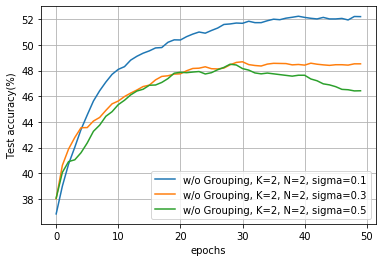

In [81]:
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]

plt.plot(acc_test_arr_K4_G1_v2[0,0,0,0:50],label='w/o Grouping, K=2, N=2, sigma=0.1' )
plt.plot(acc_test_arr_K4_G1_v2[1,0,0,0:50],label='w/o Grouping, K=2, N=2, sigma=0.3' )
plt.plot(acc_test_arr_K4_G1_v2[2,0,0,0:50],label='w/o Grouping, K=2, N=2, sigma=0.5' )
# plt.plot(acc_test_arr_K4_G1[0,3,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.001' )
# plt.plot(acc_test_arr_K4_G1[0,4,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.0005' )


# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 2.2. K=2, T=0 (without noise)

In [99]:
# K=2
# T=3
# j_array = np.array(range(K+T))
# alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print(alpha_array)

print(alpha_array[Signal_Alloc])

print(z_array)

print(dec_z_array)

print(idxs_users)

[-0.58778525  0.58778525]
[-0.81, 0.81]
[-0.81]
[0 1]


In [101]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 2
T = 0
sigma = 1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
# alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
alpha_array = np.array([-5.87785252e-01, 5.87785252e-01])
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [2]

lr_array = [0.001, 0.0003, 0.0001, 0.00003] # 0.001 is the bset


B_array = [0.5]

N_trials = 1
N_epochs = 10



loss_test_arr_K2_G1_T0_v1 = np.zeros((len(N_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K2_G1_T0_v1  = np.zeros((len(N_array),len(lr_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
        
        
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        i_array = np.array(range(N))
#         z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
        z_array = [-0.81, 0.81]
#         z_array = alpha_array - 0.05
        
        print('z_array:',z_array)
#         for j in range(len(z_array)):
#             print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
#                 coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
                    print('local update, idx=',idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                print('dec z_array=',dec_z_array)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K2_G1_T0_v1[N_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K2_G1_T0_v1[N_idx][lr_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

Learning Rate = 0.001



z_array: [-0.81, 0.81]
@BACC_Enc: N,K,T, m_i= 2 2 0 25000 

@BACC_Enc: N,K,T, m_i= 2 2 0 25000 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 5634018.6192 
Accuracy: 861/10000 (8.61%)

Round   0, Average loss 5634018.619 Test accuracy 8.610
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 57287201.1812 
Accuracy: 1474/10000 (14.74%)

Round   1, Average loss 57287201.181 Test accuracy 14.740
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 314855690.2992 
Accuracy: 1928/10000 (19.28%)

Round   2, Average loss 314855690.299 Test accuracy 19.280
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 1074226853.8176 
Accuracy: 2011/10000 (20.11%)

Round   3, Average loss 

local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 3.4327 
Accuracy: 4168/10000 (41.68%)

Round   5, Average loss 3.433 Test accuracy 41.680
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 5.2844 
Accuracy: 4118/10000 (41.18%)

Round   6, Average loss 5.284 Test accuracy 41.180
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 8.6784 
Accuracy: 4085/10000 (40.85%)

Round   7, Average loss 8.678 Test accuracy 40.850
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 14.4921 
Accuracy: 4011/10000 (40.11%)

Round   8, Average loss 14.492 Test accuracy 40.110
selected users: [0 1]
local update, idx= 0
local update, idx= 1
dec z_array= [-0.81, 0.81]

Test set: Average loss: 24.2211 
Accuracy: 4057/10000 (40.57%)

Round   9, Average loss 24.221 Test accuracy 40.570


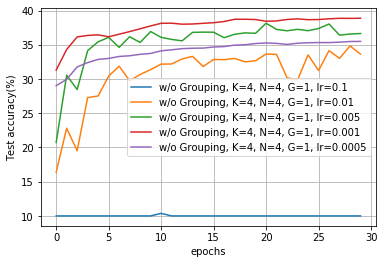

In [50]:
# lr_array = [0.1, 0.01, 0.005, 0.001,0.0005]

plt.plot(acc_test_arr_K4_G1[0,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.1' )
plt.plot(acc_test_arr_K4_G1[0,1,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.01' )
plt.plot(acc_test_arr_K4_G1[0,2,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.005' )
plt.plot(acc_test_arr_K4_G1[0,3,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.001' )
plt.plot(acc_test_arr_K4_G1[0,4,0,0:30],label='w/o Grouping, K=4, N=4, G=1, lr=0.0005' )


# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

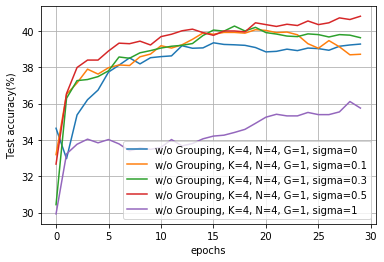

In [56]:
plt.plot(acc_test_arr_K4_G1_v1[0,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=0' )
plt.plot(acc_test_arr_K4_G1_v1[1,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=0.1' )
plt.plot(acc_test_arr_K4_G1_v1[2,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=0.3' )
plt.plot(acc_test_arr_K4_G1_v1[3,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=0.5' )
plt.plot(acc_test_arr_K4_G1_v1[4,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=1' )


# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

## 2.2. K=4

In [84]:
class my_argument:    
    epochs    = 16    #"rounds of training"
    num_users = 4  # "number of users: K"
    frac      = 0.5 #"the fraction of clients: C"
    local_ep  = 5 #"the number of local epochs: E"
    local_bs  = 50  #"local batch size: B"
    bs        = 50 #"test batch size"
    lr        = 0.0001 #"learning rate"
    momentum  = 0.5 # "SGD momentum (default: 0.5)"
    weight_decay = 5e-4
    split     = 'user' # "train-test split type, user or sample"
    opt='ADAM'
    loss='Custom' # 'Custom' or 'Default'

    # model arguments
    model = 'cnn'
    kernel_num=9 #, help='number of each kind of kernel')
    kernel_sizes='3,4,5' #  help='comma-separated kernel size to use for convolution')
    norm='batch_norm' #, help="batch_norm, layer_norm, or None")
    num_filters=32 #, help="number of filters for conv nets")
    max_pool='True' #help="Whether use max pooling rather than strided convolutions")

    # other arguments
    dataset='cifar' #, help="name of dataset")
    iid=1
    num_classes=10#, help="number of classes")
    num_channels=1#, help="number of channels of imges")
    gpu=1#, help="GPU ID, -1 for CPU")
    stopping_rounds=10#, help='rounds of early stopping')
    verbose='False'#, help='verbose print')
    seed=1#, help='random seed (default: 1)')
    
args = my_argument()

args.device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() and args.gpu != -1 else 'cpu')

use_cuda = torch.cuda.is_available()
print(use_cuda)
args.device = torch.device("cuda" if use_cuda else "cpu")
print(args.device)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# trainset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=True, download=True, transform=transform_train)
# trainloader = torch.utils.data.DataLoader(
#     trainset, batch_size=args.bs, shuffle=True, num_workers=2)

# testset = torchvision.datasets.CIFAR10(
#     root="./data/cifar", train=False, download=True, transform=transform_test)
# testloader = torch.utils.data.DataLoader(
#     testset, batch_size=args.bs, shuffle=False, num_workers=2)

dataset_train = datasets.CIFAR10('../data/cifar', train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10('../data/cifar', train=False, download=True, transform=transform_test)
if args.iid:
    dict_users = cifar_iid(dataset_train, args.num_users)

True
cuda
Files already downloaded and verified
Files already downloaded and verified


In [85]:
encoding_input_array_np = np.empty((len(dataset_train),32*32*3))
encoding_label_array_np = np.empty((len(dataset_train),args.num_classes))
print("size of X:" ,encoding_input_array_np.shape)
print("size of Y:" ,encoding_label_array_np.shape)

Size_submatrices = int(50000/args.num_users)


for i in range(args.num_users):
    
    stt_pos = i*Size_submatrices
    end_pos = (i+1)*Size_submatrices
#     print(i,stt_pos,end_pos)
    Temp_train = DataLoader(DatasetSplit(dataset_train, dict_users[i]), batch_size=Size_submatrices, shuffle=True)
    
    for batch_idx, (images, labels) in enumerate(Temp_train):
        
        images_np = images.detach().cpu().numpy()
        
#         print(np.size(images_np))
        encoding_input_array_np[stt_pos:end_pos,:] = np.reshape(images_np, (Size_submatrices,32*32*3))
#         print(encoding_input_array_np[stt_pos:end_pos,:].shape)

        onehot_labels = torch.nn.functional.one_hot(labels,num_classes=args.num_classes)
        labels_np = onehot_labels.detach().cpu().numpy()
#         print(labels_np.shape)
        encoding_label_array_np[stt_pos:end_pos,:] = labels_np
    
print(np.shape(encoding_label_array_np))

size of X: (50000, 3072)
size of Y: (50000, 10)
(50000, 10)


In [90]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 4
T = 5
sigma = 0.1
Noise_Alloc = [0,2,4,6,8]

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [4]
lr_array = [0.0003, 0.0001,0.00001]

N_trials = 1
N_epochs = 50



loss_test_arr_K4_G1 = np.zeros((len(N_array),len(lr_array),N_trials,N_epochs))
acc_test_arr_K4_G1  = np.zeros((len(N_array),len(lr_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for lr_idx in range(len(lr_array)):
        
        args.lr = lr_array[lr_idx]
        
        print('Learning Rate =',args.lr)
        print('\n\n')
        
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        z_array = np.array([-0.94, -0.125, 0.125, 0.94])
        
        print('z_array:',z_array)
        for j in range(len(z_array)):
            print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
                coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, sigma, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
                    w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                     w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1[N_idx][lr_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1[N_idx][lr_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

Learning Rate = 0.0003



z_array: [-0.94  -0.125  0.125  0.94 ]
2.21641645756389
2.3227453960929183
2.3227453960929143
2.2164164575638967
@BACC_Enc: N,K,T, m_i= 4 4 5 12500 

@BACC_Enc: N,K,T, m_i= 4 4 5 12500 

(T, sigma)= 5 0.1 )  0 -th Trial!!
selected users: [0 1 2 3]
conv1.weight 0.004408774905734592
conv1.bias 0.0021447010027865567
conv2.weight 0.0022142225503921508
conv2.bias 0.0022520122583955526
fc1.weight 0.0008317233721415202
fc1.bias 0.001049309844772021
fc2.weight 0.0027757147001841714
fc2.bias 0.002541865089109966
fc3.weight 0.003999469393775577
fc3.bias 0.00372687429189682

Test set: Average loss: 1.8705 
Accuracy: 3354/10000 (33.54%)

Round   0, Average loss 1.871 Test accuracy 33.540
selected users: [0 1 2 3]
conv1.weight 0.0016817679670121934
conv1.bias 0.0021965603033701577
conv2.weight 0.001045664350191752
conv2.bias 0.000929871283005923
fc1.weight 0.00014873554309209188
fc1.bias 0.0006081864237785339
fc2.weight 0.00029480980029181826
fc2.bias 0.0009684354244243531


Test set: Average loss: 1.7057 
Accuracy: 3847/10000 (38.47%)

Round  17, Average loss 1.706 Test accuracy 38.470
selected users: [0 1 2 3]
conv1.weight 0.0011297432581583659
conv1.bias 0.004149909441669782
conv2.weight 0.0013155607382456462
conv2.bias 0.0019702562130987644
fc1.weight 0.0003535968065261841
fc1.bias 0.0013037143896023433
fc2.weight 0.0009229827494848343
fc2.bias 0.0015515151123205821
fc3.weight 0.0014504151684897287
fc3.bias 0.0008864600211381912

Test set: Average loss: 1.7075 
Accuracy: 3842/10000 (38.42%)

Round  18, Average loss 1.708 Test accuracy 38.420
selected users: [0 1 2 3]
conv1.weight 0.0011328507794274225
conv1.bias 0.004153447225689888
conv2.weight 0.001319304903348287
conv2.bias 0.001985051902011037
fc1.weight 0.00035400442282358804
fc1.bias 0.0012982214490572612
fc2.weight 0.0009255249348897783
fc2.bias 0.001542101658525921
fc3.weight 0.0014532635609308879
fc3.bias 0.0008730735629796982

Test set: Average loss: 1.7076 
Accuracy: 3844/10000 (38.44%)

Ro


Test set: Average loss: 1.7017 
Accuracy: 3865/10000 (38.65%)

Round  35, Average loss 1.702 Test accuracy 38.650
selected users: [0 1 2 3]
conv1.weight 0.0011526423030429416
conv1.bias 0.004082895504931609
conv2.weight 0.0013172326485315958
conv2.bias 0.002127000829204917
fc1.weight 0.0003516292969385783
fc1.bias 0.001267355183760325
fc2.weight 0.0009272112732841855
fc2.bias 0.0015429412680012839
fc3.weight 0.0014641466594877697
fc3.bias 0.000826747715473175

Test set: Average loss: 1.7019 
Accuracy: 3860/10000 (38.60%)

Round  36, Average loss 1.702 Test accuracy 38.600
selected users: [0 1 2 3]
conv1.weight 0.0011528632375929092
conv1.bias 0.004077227475742499
conv2.weight 0.0013163634141286215
conv2.bias 0.0021307305432856083
fc1.weight 0.00035136282444000246
fc1.bias 0.0012667407592137656
fc2.weight 0.0009270713442847842
fc2.bias 0.0015449536343415577
fc3.weight 0.001463214982123602
fc3.bias 0.0008275261148810387

Test set: Average loss: 1.7021 
Accuracy: 3859/10000 (38.59%)

Rou


Test set: Average loss: 1.8990 
Accuracy: 3068/10000 (30.68%)

Round   3, Average loss 1.899 Test accuracy 30.680
selected users: [0 1 2 3]
conv1.weight 0.0007166657182905409
conv1.bias 0.0010365045939882596
conv2.weight 0.0006200151642163595
conv2.bias 0.0005718945758417249
fc1.weight 0.00017848682403564454
fc1.bias 0.00028984158610304196
fc2.weight 0.00036740731152277143
fc2.bias 0.0004028716967219398
fc3.weight 0.00034995050657363164
fc3.bias 0.00013132793828845023

Test set: Average loss: 1.8957 
Accuracy: 3054/10000 (30.54%)

Round   4, Average loss 1.896 Test accuracy 30.540
selected users: [0 1 2 3]
conv1.weight 0.0006638177235921224
conv1.bias 0.001014965819194913
conv2.weight 0.0006196259458859762
conv2.bias 0.0005901010008528829
fc1.weight 0.00018434953689575194
fc1.bias 0.0003316703562935193
fc2.weight 0.00040758677891322546
fc2.bias 0.00045321260889371234
fc3.weight 0.0003725159026327587
fc3.bias 0.0001826892839744687

Test set: Average loss: 1.8951 
Accuracy: 3037/10000 (


Test set: Average loss: 1.8852 
Accuracy: 3033/10000 (30.33%)

Round  21, Average loss 1.885 Test accuracy 30.330
selected users: [0 1 2 3]
conv1.weight 0.0004693902532259623
conv1.bias 0.0009330962784588337
conv2.weight 0.0006042206287384033
conv2.bias 0.0005942056886851788
fc1.weight 0.00019933895270029704
fc1.bias 0.000360421525935332
fc2.weight 0.0005026133287520636
fc2.bias 0.0004941824646223159
fc3.weight 0.0004544671092714582
fc3.bias 0.00031767126638442277

Test set: Average loss: 1.8849 
Accuracy: 3038/10000 (30.38%)

Round  22, Average loss 1.885 Test accuracy 30.380
selected users: [0 1 2 3]
conv1.weight 0.00046814673476749
conv1.bias 0.0009320816025137901
conv2.weight 0.0006066239873568217
conv2.bias 0.000592504336964339
fc1.weight 0.00019925816853841145
fc1.bias 0.0003604581579566002
fc2.weight 0.0005024419417456975
fc2.bias 0.0004955436590881575
fc3.weight 0.00045412775306474595
fc3.bias 0.00031893253326416017

Test set: Average loss: 1.8845 
Accuracy: 3040/10000 (30.40%


Test set: Average loss: 1.8856 
Accuracy: 3037/10000 (30.37%)

Round  39, Average loss 1.886 Test accuracy 30.370
selected users: [0 1 2 3]
conv1.weight 0.00045220461156633164
conv1.bias 0.0009071256499737501
conv2.weight 0.0006356530388196309
conv2.bias 0.0005758445477113128
fc1.weight 0.00019747430086135864
fc1.bias 0.0003702091984450817
fc2.weight 0.0005009447298352681
fc2.bias 0.0005147172847674007
fc3.weight 0.0004530283312002818
fc3.bias 0.00034312300849705937

Test set: Average loss: 1.8858 
Accuracy: 3035/10000 (30.35%)

Round  40, Average loss 1.886 Test accuracy 30.350
selected users: [0 1 2 3]
conv1.weight 0.0004516772760285272
conv1.bias 0.0009058659585813681
conv2.weight 0.000636013150215149
conv2.bias 0.0005766746471635997
fc1.weight 0.00019751209020614624
fc1.bias 0.00037142746150493623
fc2.weight 0.0005007069262247237
fc2.bias 0.0005142957947793461
fc3.weight 0.00045297209705625263
fc3.bias 0.0003433974925428629

Test set: Average loss: 1.8859 
Accuracy: 3038/10000 (30


Test set: Average loss: 2.1862 
Accuracy: 1450/10000 (14.50%)

Round   6, Average loss 2.186 Test accuracy 14.500
selected users: [0 1 2 3]
conv1.weight 8.37604370382097e-05
conv1.bias 0.00014556870640565953
conv2.weight 0.00020015568782885869
conv2.bias 3.0725823307875544e-05
fc1.weight 8.13421110312144e-05
fc1.bias 0.00013441710422436396
fc2.weight 0.00013337615463468764
fc2.bias 0.0001325411500320548
fc3.weight 8.650473540737516e-05
fc3.bias 6.0153903905302283e-05

Test set: Average loss: 2.1860 
Accuracy: 1721/10000 (17.21%)

Round   7, Average loss 2.186 Test accuracy 17.210
selected users: [0 1 2 3]
conv1.weight 7.274679839611053e-05
conv1.bias 0.00012754156099011502
conv2.weight 0.00019004767139752706
conv2.bias 2.9042539608781226e-05
fc1.weight 8.242616057395935e-05
fc1.bias 0.00013979047847290834
fc2.weight 0.00014356722434361776
fc2.bias 0.00014518221308078085
fc3.weight 9.761220287709009e-05
fc3.bias 5.999448476359248e-05

Test set: Average loss: 2.1849 
Accuracy: 1753/1000


Test set: Average loss: 2.1753 
Accuracy: 1756/10000 (17.56%)

Round  24, Average loss 2.175 Test accuracy 17.560
selected users: [0 1 2 3]
conv1.weight 6.480139990647633e-05
conv1.bias 9.374887061615785e-05
conv2.weight 0.00016895057012637456
conv2.bias 3.3105723559856415e-05
fc1.weight 8.968120813369752e-05
fc1.bias 0.00013089569595952827
fc2.weight 0.00018611372936339605
fc2.bias 0.0001717913518881514
fc3.weight 0.00014343237770455224
fc3.bias 5.90900017414242e-05

Test set: Average loss: 2.1752 
Accuracy: 1754/10000 (17.54%)

Round  25, Average loss 2.175 Test accuracy 17.540
selected users: [0 1 2 3]
conv1.weight 6.481821752256817e-05
conv1.bias 9.365565104720493e-05
conv2.weight 0.00016892507672309877
conv2.bias 3.30942748405505e-05
fc1.weight 8.97061824798584e-05
fc1.bias 0.00013085834992428622
fc2.weight 0.00018619216150707668
fc2.bias 0.00017177331305685497
fc3.weight 0.0001434977122005962
fc3.bias 5.912710330449045e-05

Test set: Average loss: 2.1752 
Accuracy: 1753/10000 (1


Test set: Average loss: 2.1751 
Accuracy: 1754/10000 (17.54%)

Round  42, Average loss 2.175 Test accuracy 17.540
selected users: [0 1 2 3]
conv1.weight 6.487645208835602e-05
conv1.bias 9.336433140560985e-05
conv2.weight 0.0001688415432969729
conv2.bias 3.3102034649346024e-05
fc1.weight 8.979696035385131e-05
fc1.bias 0.00013096630573272705
fc2.weight 0.000186523109201401
fc2.bias 0.00017181166359001682
fc3.weight 0.00014376010568369004
fc3.bias 5.917678936384618e-05

Test set: Average loss: 2.1751 
Accuracy: 1754/10000 (17.54%)

Round  43, Average loss 2.175 Test accuracy 17.540
selected users: [0 1 2 3]
conv1.weight 6.487151400910483e-05
conv1.bias 9.334313411576052e-05
conv2.weight 0.0001688415308793386
conv2.bias 3.309065505163744e-05
fc1.weight 8.979596694310506e-05
fc1.bias 0.00013095860679944357
fc2.weight 0.00018652178465373932
fc2.bias 0.00017183555644892512
fc3.weight 0.0001437586865254811
fc3.bias 5.916402442380786e-05

Test set: Average loss: 2.1751 
Accuracy: 1754/10000 (1

# 2.3. K=4, N=4, T=3, G=2, with grouping

In [91]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

G = 2
N = 4 # N should be divisible by G
K = 4 # N should be divisible by G

size_per_group = int(50000/G)

X_group = np.reshape(encoding_input_array_np, (G,size_per_group,32*32*3))
y_group = np.reshape(encoding_label_array_np, (G,size_per_group,args.num_classes)) 

N_i = int(N/G) # = 2
K_i = int(K/G) # = 2
T = 3
sigma = 0.1
Noise_Alloc = [0,2,4]
m = N_i # number of selected workers (if there is no straggler, m=N_i)

print(N_i,K_i,T)

Signal_Alloc = []
for i in range(K_i+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K_i+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K_i+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

z_array = np.array([-0.81, 0.81])

B = 0.5

N_trials = 1

N_epochs = 50

lr_array = [0.0003, 0.0001, 0.00001]


loss_test_arr_K4_G2 = np.zeros((len(lr_array),N_epochs))
acc_test_arr_K4_G2  = np.zeros((len(lr_array),N_epochs))

for lr_idx in range(len(lr_array)):
    
    args.lr = lr_array[lr_idx]
    
    print('##########################################')
    print('Learning Rate =',args.lr)
    print('\n\n')
        
#     print('##########################################')
#     print('######',trial_idx,'-th Trial!! ###########')
    
    net_glob = CNNCifar(args=args)
    net_glob.cuda()
    net_glob.train()
    
    # copy weights
    w_glob = net_glob.state_dict()
    
    X_tilde = np.empty((N,Size_submatrices,32*32*3))
    y_tilde = np.empty((N,Size_submatrices,10))
    
    for G_idx in range(G):
        
        _Noise_label = np.ones((size_per_group*T,10)) * 0.1
        
        X_tilde_tmp,a,b = BACC_Enc_Data_v3(X_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde_tmp,a,b = BACC_Enc_Data_v3(y_group[G_idx,:,:], N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)
        
        stt_pos = G_idx * N_i
        end_pos = (G_idx+1) * N_i
        
        X_tilde[stt_pos:end_pos,:,:] = X_tilde_tmp
        y_tilde[stt_pos:end_pos,:,:] = y_tilde_tmp
        
   

    for iter in range(N_epochs): #args.epochs
        
        w_group_array = []
        for G_idx in range(G):
            w_locals, loss_locals = [], []
            idxs_users = np.random.choice(range(N_i), m, replace=False)
            idxs_users = np.sort(idxs_users)
            print('selected users:',idxs_users)

            coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N_i, K_i, T, sigma, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

            dec_z_array = []
            for idx in idxs_users: #for idx in range(N):
        #         print(idx)
                local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[G_idx*N_i+idx,:,:], label=y_tilde[G_idx*N_i+idx,:,:])
                w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
#                 w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                w_locals.append(copy.deepcopy(w))
                loss_locals.append(copy.deepcopy(loss))

                dec_z_array.append(z_array[idx])


            # update global weights
            #w_glob = FedAvg(w_locals)
            w_group = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)
            
            w_group_array.append(copy.deepcopy(w_group))
        
        w_glob = copy.deepcopy(w_group_array[0])
        for k in w_glob.keys():
            for G_idx in range(1,G):
                w_glob[k] += w_group_array[G_idx][k]
            w_glob[k] = torch.div(w_glob[k], len(w_group_array))
        
        # copy weight to net_glob
        net_glob.load_state_dict(w_glob)

        # print loss
    #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

    #     loss_train_arr.append(loss_train)

        acc_test, loss_test = test_img(net_glob, dataset_test, args)
        acc_test_arr_K4_G2[lr_idx][iter] = acc_test
        loss_test_arr_K4_G2[lr_idx][iter] = loss_test
        
        if iter % 1 ==0:
            print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))

        
        
    

2 2 3
##########################################
Learning Rate = 0.0003



@BACC_Enc: N,K,T, m_i= 2 2 3 12500 

@BACC_Enc: N,K,T, m_i= 2 2 3 12500 

@BACC_Enc: N,K,T, m_i= 2 2 3 12500 

@BACC_Enc: N,K,T, m_i= 2 2 3 12500 

selected users: [0 1]
conv1.weight 0.004624962276882596
conv1.bias 0.00348116767903169
conv2.weight 0.0022326672077178956
conv2.bias 0.00137176807038486
fc1.weight 0.0008272260030110677
fc1.bias 0.000765727957089742
fc2.weight 0.002760102635338193
fc2.bias 0.002314757200933638
fc3.weight 0.0039475418272472565
fc3.bias 0.006210942566394806
selected users: [0 1]
conv1.weight 0.004624962276882596
conv1.bias 0.00348116767903169
conv2.weight 0.0022326672077178956
conv2.bias 0.00137176807038486
fc1.weight 0.0008272260030110677
fc1.bias 0.000765727957089742
fc2.weight 0.002760102635338193
fc2.bias 0.002314757200933638
fc3.weight 0.0039475418272472565
fc3.bias 0.006210942566394806

Test set: Average loss: 1.8556 
Accuracy: 3461/10000 (34.61%)

selected users: [0 1]
conv1.wei


Test set: Average loss: 1.6272 
Accuracy: 4183/10000 (41.83%)

selected users: [0 1]
conv1.weight 0.002068025536007351
conv1.bias 0.0050210921714703245
conv2.weight 0.0011708125472068786
conv2.bias 0.0029851372819393873
fc1.weight 0.00042226672172546387
fc1.bias 0.0019063770771026612
fc2.weight 0.001205138365427653
fc2.bias 0.002389322966337204
fc3.weight 0.002207654146921067
fc3.bias 0.0014099580235779285
selected users: [0 1]
conv1.weight 0.002068025536007351
conv1.bias 0.0050210921714703245
conv2.weight 0.0011708125472068786
conv2.bias 0.0029851372819393873
fc1.weight 0.00042226672172546387
fc1.bias 0.0019063770771026612
fc2.weight 0.001205138365427653
fc2.bias 0.002389322966337204
fc3.weight 0.002207654146921067
fc3.bias 0.0014099580235779285

Test set: Average loss: 1.6266 
Accuracy: 4182/10000 (41.82%)

selected users: [0 1]
conv1.weight 0.0020387825700971815
conv1.bias 0.004741770525773366
conv2.weight 0.0011775829394658406
conv2.bias 0.003014493966475129
fc1.weight 0.000424569


Test set: Average loss: 1.6143 
Accuracy: 4253/10000 (42.53%)

selected users: [0 1]
conv1.weight 0.001985349390241835
conv1.bias 0.0039871906240781145
conv2.weight 0.001252311368783315
conv2.bias 0.0030225543305277824
fc1.weight 0.00042547714710235596
fc1.bias 0.0018574825177590053
fc2.weight 0.0012355556563725548
fc2.bias 0.0019663751480125244
fc3.weight 0.002306251298813593
fc3.bias 0.001021323073655367
selected users: [0 1]
conv1.weight 0.001985349390241835
conv1.bias 0.0039871906240781145
conv2.weight 0.001252311368783315
conv2.bias 0.0030225543305277824
fc1.weight 0.00042547714710235596
fc1.bias 0.0018574825177590053
fc2.weight 0.0012355556563725548
fc2.bias 0.0019663751480125244
fc3.weight 0.002306251298813593
fc3.bias 0.001021323073655367

Test set: Average loss: 1.6136 
Accuracy: 4252/10000 (42.52%)

selected users: [0 1]
conv1.weight 0.0019939475589328343
conv1.bias 0.003974707797169685
conv2.weight 0.001254809300104777
conv2.bias 0.003010490909218788
fc1.weight 0.0004253844


Test set: Average loss: 1.6113 
Accuracy: 4257/10000 (42.57%)

selected users: [0 1]
conv1.weight 0.0020865628454420303
conv1.bias 0.003981519490480423
conv2.weight 0.0012780530254046121
conv2.bias 0.003024316392838955
fc1.weight 0.00042677577336629234
fc1.bias 0.0019537687301635744
fc2.weight 0.0012462912097809806
fc2.bias 0.001934131518715904
fc3.weight 0.0023360996019272575
fc3.bias 0.0010004233568906783
selected users: [0 1]
conv1.weight 0.0020865628454420303
conv1.bias 0.003981519490480423
conv2.weight 0.0012780530254046121
conv2.bias 0.003024316392838955
fc1.weight 0.00042677577336629234
fc1.bias 0.0019537687301635744
fc2.weight 0.0012462912097809806
fc2.bias 0.001934131518715904
fc3.weight 0.0023360996019272575
fc3.bias 0.0010004233568906783

Test set: Average loss: 1.6102 
Accuracy: 4259/10000 (42.59%)

selected users: [0 1]
conv1.weight 0.0020952455202738443
conv1.bias 0.0039873675753672915
conv2.weight 0.0012810722986857097
conv2.bias 0.0030325278639793396
fc1.weight 0.00042


Test set: Average loss: 1.6066 
Accuracy: 4321/10000 (43.21%)

selected users: [0 1]
conv1.weight 0.0021628603670332167
conv1.bias 0.004232822917401791
conv2.weight 0.0013162465890248617
conv2.bias 0.0030311881564557552
fc1.weight 0.0004281757672627767
fc1.bias 0.0020319387316703797
fc2.weight 0.0012420713901519775
fc2.bias 0.001923813528957821
fc3.weight 0.002332566465650286
fc3.bias 0.0010060954838991166
selected users: [0 1]
conv1.weight 0.0021628603670332167
conv1.bias 0.004232822917401791
conv2.weight 0.0013162465890248617
conv2.bias 0.0030311881564557552
fc1.weight 0.0004281757672627767
fc1.bias 0.0020319387316703797
fc2.weight 0.0012420713901519775
fc2.bias 0.001923813528957821
fc3.weight 0.002332566465650286
fc3.bias 0.0010060954838991166

Test set: Average loss: 1.6061 
Accuracy: 4320/10000 (43.20%)

selected users: [0 1]
conv1.weight 0.002170461548699273
conv1.bias 0.004270423203706741
conv2.weight 0.001318687895933787
conv2.bias 0.0030280309729278088
fc1.weight 0.0004280548

selected users: [0 1]
conv1.weight 0.0010019915633731418
conv1.bias 0.0015912467303375404
conv2.weight 0.0006062085429827372
conv2.bias 0.0005206484347581863
fc1.weight 0.00019820082187652587
fc1.bias 0.0004529726381103198
fc2.weight 0.00044906290750654915
fc2.bias 0.0007180345821238699
fc3.weight 0.00047662066561835153
fc3.bias 0.000245605013333261

Test set: Average loss: 1.8787 
Accuracy: 3099/10000 (30.99%)

selected users: [0 1]
conv1.weight 0.0008946618768903944
conv1.bias 0.0014858466262618701
conv2.weight 0.0005687315265337626
conv2.bias 0.0005766261601820588
fc1.weight 0.00020881307125091554
fc1.bias 0.0005083927263816198
fc2.weight 0.0005082405275768704
fc2.bias 0.000800465898854392
fc3.weight 0.0005038786502111525
fc3.bias 0.0002924830187112093
selected users: [0 1]
conv1.weight 0.0008946618768903944
conv1.bias 0.0014858466262618701
conv2.weight 0.0005687315265337626
conv2.bias 0.0005766261601820588
fc1.weight 0.00020881307125091554
fc1.bias 0.0005083927263816198
fc2.weight 

selected users: [0 1]
conv1.weight 0.0006252874268425835
conv1.bias 0.0012373197823762894
conv2.weight 0.0006320318082968394
conv2.bias 0.0007912039291113615
fc1.weight 0.00023296227057774863
fc1.bias 0.000603011002143224
fc2.weight 0.0006138760892171708
fc2.bias 0.0008676293350401379
fc3.weight 0.0005979090929031372
fc3.bias 0.00048734401352703573

Test set: Average loss: 1.8804 
Accuracy: 3077/10000 (30.77%)

selected users: [0 1]
conv1.weight 0.0006227070755428738
conv1.bias 0.0012227777236451705
conv2.weight 0.0006343868374824524
conv2.bias 0.0007857909658923745
fc1.weight 0.00023368322849273682
fc1.bias 0.0006005254263679187
fc2.weight 0.0006156520237998356
fc2.bias 0.0008656177669763565
fc3.weight 0.0005995645409538632
fc3.bias 0.0004927472211420536
selected users: [0 1]
conv1.weight 0.0006227070755428738
conv1.bias 0.0012227777236451705
conv2.weight 0.0006343868374824524
conv2.bias 0.0007857909658923745
fc1.weight 0.00023368322849273682
fc1.bias 0.0006005254263679187
fc2.weight 

selected users: [0 1]
conv1.weight 0.0006080614195929634
conv1.bias 0.0011378748652835686
conv2.weight 0.0006448291738828023
conv2.bias 0.0007430773111991584
fc1.weight 0.0002365602453549703
fc1.bias 0.0005627918367584546
fc2.weight 0.0006214027839993673
fc2.bias 0.0008497917581172217
fc3.weight 0.000607715972832271
fc3.bias 0.0005234021693468094

Test set: Average loss: 1.8754 
Accuracy: 3108/10000 (31.08%)

selected users: [0 1]
conv1.weight 0.0006072478824191624
conv1.bias 0.0011330663692206144
conv2.weight 0.0006446332236131032
conv2.bias 0.0007396798464469612
fc1.weight 0.00023666687806447347
fc1.bias 0.0005587667226791381
fc2.weight 0.0006212096838724045
fc2.bias 0.0008465720429306938
fc3.weight 0.0006080017912955512
fc3.bias 0.0005238738842308522
selected users: [0 1]
conv1.weight 0.0006072478824191624
conv1.bias 0.0011330663692206144
conv2.weight 0.0006446332236131032
conv2.bias 0.0007396798464469612
fc1.weight 0.00023666687806447347
fc1.bias 0.0005587667226791381
fc2.weight 0.

selected users: [0 1]
conv1.weight 0.0006007762749989827
conv1.bias 0.0011071295011788607
conv2.weight 0.0006428345044453939
conv2.bias 0.0007177084335125983
fc1.weight 0.00023867477973302204
fc1.bias 0.0004912075276176135
fc2.weight 0.0006211754821595692
fc2.bias 0.0008043022382827033
fc3.weight 0.000609235181694939
fc3.bias 0.0005283777136355639

Test set: Average loss: 1.8757 
Accuracy: 3104/10000 (31.04%)

selected users: [0 1]
conv1.weight 0.0006001252598232693
conv1.bias 0.0011050514876842499
conv2.weight 0.0006425145268440246
conv2.bias 0.0007145157433114946
fc1.weight 0.00023883897066116332
fc1.bias 0.00048418333753943445
fc2.weight 0.0006214070414739942
fc2.bias 0.0007998923815432049
fc3.weight 0.0006093177057447887
fc3.bias 0.0005283576436340808
selected users: [0 1]
conv1.weight 0.0006001252598232693
conv1.bias 0.0011050514876842499
conv2.weight 0.0006425145268440246
conv2.bias 0.0007145157433114946
fc1.weight 0.00023883897066116332
fc1.bias 0.00048418333753943445
fc2.weight

selected users: [0 1]
conv1.weight 0.0005940681033664279
conv1.bias 0.0011041201651096344
conv2.weight 0.0006452515224615733
conv2.bias 0.0006967938970774412
fc1.weight 0.00023906517028808593
fc1.bias 0.00046481369063258173
fc2.weight 0.0006235794415549626
fc2.bias 0.0007774287923460914
fc3.weight 0.0006095977056594122
fc3.bias 0.0005267974454909563

Test set: Average loss: 1.8751 
Accuracy: 3109/10000 (31.09%)

selected users: [0 1]
conv1.weight 0.0005931397941377428
conv1.bias 0.0011035130204011996
conv2.weight 0.0006459497412045796
conv2.bias 0.0006955794524401426
fc1.weight 0.00023896968364715577
fc1.bias 0.0004653523986538251
fc2.weight 0.0006236214486379472
fc2.bias 0.0007774063519069127
fc3.weight 0.0006095400168782189
fc3.bias 0.0005278576165437699
selected users: [0 1]
conv1.weight 0.0005931397941377428
conv1.bias 0.0011035130204011996
conv2.weight 0.0006459497412045796
conv2.bias 0.0006955794524401426
fc1.weight 0.00023896968364715577
fc1.bias 0.0004653523986538251
fc2.weight


Test set: Average loss: 2.1028 
Accuracy: 1834/10000 (18.34%)

selected users: [0 1]
conv1.weight 0.0001660061213705275
conv1.bias 0.0003069932960594694
conv2.weight 0.00016129213074843088
conv2.bias 0.00018667717813514173
fc1.weight 0.00011655691266059876
fc1.bias 0.00013296666244665782
fc2.weight 0.00017790540106712825
fc2.bias 0.0001264628843360004
fc3.weight 0.00010336854805548986
fc3.bias 9.206641698256135e-06
selected users: [0 1]
conv1.weight 0.0001660061213705275
conv1.bias 0.0003069932960594694
conv2.weight 0.00016129213074843088
conv2.bias 0.00018667717813514173
fc1.weight 0.00011655691266059876
fc1.bias 0.00013296666244665782
fc2.weight 0.00017790540106712825
fc2.bias 0.0001264628843360004
fc3.weight 0.00010336854805548986
fc3.bias 9.206641698256135e-06

Test set: Average loss: 2.1026 
Accuracy: 1827/10000 (18.27%)

selected users: [0 1]
conv1.weight 0.00016460327638520136
conv1.bias 0.00030780376012747485
conv2.weight 0.00016014815618594489
conv2.bias 0.0001873540459200739

selected users: [0 1]
conv1.weight 0.0001633169584804111
conv1.bias 0.0003122390868763129
conv2.weight 0.00015692442655563355
conv2.bias 0.0001895982277346775
fc1.weight 0.00011717134714126587
fc1.bias 0.00013809987964729468
fc2.weight 0.00018211340620404197
fc2.bias 0.0001288713732113441
fc3.weight 0.00010548496530169533
fc3.bias 9.740786481415853e-06

Test set: Average loss: 2.1027 
Accuracy: 1827/10000 (18.27%)

selected users: [0 1]
conv1.weight 0.0001633619103166792
conv1.bias 0.00031216904365768033
conv2.weight 0.00015687428414821626
conv2.bias 0.00018966490461025387
fc1.weight 0.00011719325184822083
fc1.bias 0.00013826461508870125
fc2.weight 0.00018213722440931532
fc2.bias 0.00012884509661013172
fc3.weight 0.00010546362471012842
fc3.bias 9.748512820806354e-06
selected users: [0 1]
conv1.weight 0.0001633619103166792
conv1.bias 0.00031216904365768033
conv2.weight 0.00015687428414821626
conv2.bias 0.00018966490461025387
fc1.weight 0.00011719325184822083
fc1.bias 0.00013826461508870

selected users: [0 1]
conv1.weight 0.00016347683138317532
conv1.bias 0.00031285814475268126
conv2.weight 0.0001567595824599266
conv2.bias 0.00018973441910929978
fc1.weight 0.00011720552047093709
fc1.bias 0.00013877299303809802
fc2.weight 0.0001821958829486181
fc2.bias 0.00012869488758345446
fc3.weight 0.00010538026690483093
fc3.bias 9.764605783857405e-06

Test set: Average loss: 2.1028 
Accuracy: 1827/10000 (18.27%)

selected users: [0 1]
conv1.weight 0.00016347509291436937
conv1.bias 0.00031280853242302936
conv2.weight 0.00015675269067287446
conv2.bias 0.00018973901751451194
fc1.weight 0.00011720357338587443
fc1.bias 0.0001387767493724823
fc2.weight 0.00018220172514991155
fc2.bias 0.00012869840221745626
fc3.weight 0.0001053892874291965
fc3.bias 9.763317939359694e-06
selected users: [0 1]
conv1.weight 0.00016347509291436937
conv1.bias 0.00031280853242302936
conv2.weight 0.00015675269067287446
conv2.bias 0.00018973901751451194
fc1.weight 0.00011720357338587443
fc1.bias 0.000138776749372

selected users: [0 1]
conv1.weight 0.00016350713041093614
conv1.bias 0.00031276214091728133
conv2.weight 0.00015674407283465067
conv2.bias 0.00018968936637975276
fc1.weight 0.00011719847718874613
fc1.bias 0.00013882100271681944
fc2.weight 0.00018219283175846887
fc2.bias 0.00012867652722412632
fc3.weight 0.00010538425828729356
fc3.bias 9.767893061507493e-06

Test set: Average loss: 2.1028 
Accuracy: 1827/10000 (18.27%)

selected users: [0 1]
conv1.weight 0.0001635232236650255
conv1.bias 0.0003128237440250814
conv2.weight 0.00015674586097399394
conv2.bias 0.0001897143665701151
fc1.weight 0.0001171966791152954
fc1.bias 0.00013880888000130653
fc2.weight 0.0001821912233791654
fc2.bias 0.00012868495347599188
fc3.weight 0.00010538167719330107
fc3.bias 9.767166920937597e-06
selected users: [0 1]
conv1.weight 0.0001635232236650255
conv1.bias 0.0003128237440250814
conv2.weight 0.00015674586097399394
conv2.bias 0.0001897143665701151
fc1.weight 0.0001171966791152954
fc1.bias 0.00013880888000130653

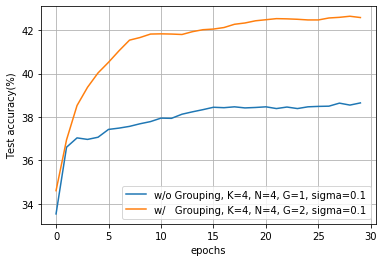

In [104]:
plt.plot(acc_test_arr_K4_G1[0,0,0,0:30],label='w/o Grouping, K=4, N=4, G=1, sigma=0.1' )
plt.plot(acc_test_arr_K4_G2[0,0:30],label='w/   Grouping, K=4, N=4, G=2, sigma=0.1' )


# plt.plot(acc_test_arr_uncoded,'r',label='uncoded')
plt.legend()
plt.grid()
# plt.title(title_name)
plt.xlabel('epochs')
plt.ylabel('Test accuracy(%)')
plt.show()

# 2.4. K=4, N=4, T=0

In [65]:
from models.Update import LocalUpdate_with_BACC
from models.Fed import FedAvg_with_BACC_Dec

from utils.functions import *
import math

K = 4
T = 0
sigma = 1
Noise_Alloc = []

Signal_Alloc = []
for i in range(K+T):
    if i not in Noise_Alloc:
        Signal_Alloc.append(i)


j_array = np.array(range(K+T))
alpha_array = np.cos((2*j_array+1)*math.pi/(2*(K+T))) #np.cos((2*j_array+1)*math.pi/(2*K))
# print("alpha_array: ",alpha_array,'\n')

B = 0.5


N_array = [5,7,9,13]
B_array = [0.5]

N_trials = 1
N_epochs = 50



loss_test_arr_K4_G1_T0 = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))
acc_test_arr_K4_G1_T0  = np.zeros((len(N_array),len(B_array),N_trials,N_epochs))

for N_idx in range(len(N_array)):
    
    N = N_array[N_idx]
    
    
           
        
    # print("alpha_array: ",alpha_array,'\n')
    
    
    for B_idx in range(len(B_array)):
        
        B = B_array[B_idx]
        z_array = []
#         while(len(z_array)<N):
#             z_tmp = np.random.uniform(-1,1,1)
#             MIS_tmp = MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_tmp], 1,sigma)
#             if MIS_tmp < B and MIS_tmp > 0.1:
#                 z_array.append(z_tmp[0])
#         
#         z_array = np.sort(z_array)
#         print(N_idx,'!!!')
#         if N_idx==0:
# #             z_array = np.array([-0.94,-0.534,0.534, 0.94])
# #         elif N_idx==1:
# #             z_array = np.array([-0.94, -0.73, 0.73, 0.94])
#         elif N_idx==1:
#             z_array = np.array([-0.94, -0.125, 0.125, 0.94])
#         else:
# #             z_array = np.array([-0.94, -0.73, -0.534, -0.125, 0.125, 0.534, 0.73, 0.94])
# #             z_array = np.array([-0.9, -0.81, -0.22, -0.20, 0.20, 0.22, 0.81, 0.9])
        
        i_array = np.array(range(N))
        z_array = np.cos(i_array*2*math.pi/N/2) # np.cos(i_array*2*math.pi/N/2)
        
        print('z_array:',z_array)
#         for j in range(len(z_array)):
#             print(MutualInformationSecurity(alpha_array[Signal_Alloc], alpha_array[Noise_Alloc],[z_array[j]], 1,sigma))
        
        
        _Noise_label = np.ones((15000*T,10)) * 0.1

        X_tilde,a,b = BACC_Enc_Data_v3(encoding_input_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc) #BACC_Enc(encoding_input_array_np, alpha_array, z_array)
        y_tilde,a,b = BACC_Enc_Data_v3(encoding_label_array_np, N, K, T, sigma, alpha_array, z_array, _Noise_Alloc = Noise_Alloc, _Noise = _Noise_label, is_predefined_noise=True) #BACC_Enc(encoding_label_array_np, alpha_array, z_array)

        m = N # m is the number of received result @ master
    #     print('number of results:',m)

        for trial_idx in range(N_trials):
            print('(T, sigma)=',T,sigma,') ',trial_idx,'-th Trial!!')

            net_glob = CNNCifar(args=args)
            net_glob.cuda()
            net_glob.train()

            # copy weights
            w_glob = net_glob.state_dict()

            for iter in range(N_epochs): #args.epochs
                w_locals, loss_locals = [], []
                idxs_users = np.random.choice(range(N), m, replace=False)
                idxs_users = np.sort(idxs_users)
                print('selected users:',idxs_users)
                
#                 coded_net = BACC_Enc_Model_withNoise_v4(net_glob.cuda(), N, K, T, 1, alpha_array, z_array, _Noise_Alloc=Noise_Alloc)

                dec_z_array = []
                for idx in idxs_users: #for idx in range(N):
            #         print(idx)
                    local = LocalUpdate_with_BACC(args=args, dataset=X_tilde[idx,:,:], label=y_tilde[idx,:,:])
#                     w, loss = local.train(net=copy.deepcopy(coded_net[idx]).cuda())
                    w, loss = local.train(net=copy.deepcopy(net_glob).cuda())
                    w_locals.append(copy.deepcopy(w))
                    loss_locals.append(copy.deepcopy(loss))

                    dec_z_array.append(z_array[idx])


                # update global weights
                #w_glob = FedAvg(w_locals)
                w_glob = FedAvg_with_BACC_Dec(w_locals, alpha_array[Signal_Alloc], dec_z_array)

                # copy weight to net_glob
                net_glob.load_state_dict(w_glob)

                # print loss
            #     acc_train, loss_train = test_img(net_glob, dataset_train, args)

            #     loss_train_arr.append(loss_train)

                acc_test, loss_test = test_img(net_glob, dataset_test, args)
                acc_test_arr_K4_G1_T0[N_idx][B_idx][trial_idx][iter] = acc_test
                loss_test_arr_K4_G1_T0[N_idx][B_idx][trial_idx][iter] = loss_test
                if iter % 1 ==0:
                    print('Round {:3d}, Average loss {:.3f} Test accuracy {:.3f}'.format(iter, loss_test, acc_test))
                #print(loss_train)

z_array: [ 1.          0.80901699  0.30901699 -0.30901699 -0.80901699]
@BACC_Enc: N,K,T, m_i= 5 4 0 12500 

@BACC_Enc: N,K,T, m_i= 5 4 0 12500 

(T, sigma)= 0 1 )  0 -th Trial!!
selected users: [0 1 2 3 4]

Test set: Average loss: 2.0013 
Accuracy: 2079/10000 (20.79%)

Round   0, Average loss 2.001 Test accuracy 20.790
selected users: [0 1 2 3 4]

Test set: Average loss: 22.4331 
Accuracy: 2126/10000 (21.26%)

Round   1, Average loss 22.433 Test accuracy 21.260
selected users: [0 1 2 3 4]

Test set: Average loss: 62.9370 
Accuracy: 1621/10000 (16.21%)

Round   2, Average loss 62.937 Test accuracy 16.210
selected users: [0 1 2 3 4]

Test set: Average loss: 142.2053 
Accuracy: 1528/10000 (15.28%)

Round   3, Average loss 142.205 Test accuracy 15.280
selected users: [0 1 2 3 4]

Test set: Average loss: 278.6917 
Accuracy: 1094/10000 (10.94%)

Round   4, Average loss 278.692 Test accuracy 10.940
selected users: [0 1 2 3 4]

Test set: Average loss: 464.2436 
Accuracy: 994/10000 (9.94%)

Rou


Test set: Average loss: 510.0565 
Accuracy: 1251/10000 (12.51%)

Round   3, Average loss 510.057 Test accuracy 12.510
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 587.4965 
Accuracy: 1110/10000 (11.10%)

Round   4, Average loss 587.496 Test accuracy 11.100
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 659.0045 
Accuracy: 1268/10000 (12.68%)

Round   5, Average loss 659.005 Test accuracy 12.680
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 735.8657 
Accuracy: 1467/10000 (14.67%)

Round   6, Average loss 735.866 Test accuracy 14.670
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 775.0035 
Accuracy: 1334/10000 (13.34%)

Round   7, Average loss 775.003 Test accuracy 13.340
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 802.8011 
Accuracy: 1260/10000 (12.60%)

Round   8, Average loss 802.801 Test accuracy 12.600
selected users: [0 1 2 3 4 5 6]

Test set: Average loss: 786.0416 
Accuracy: 1192/10000 (11.92%)

Round   9, Average loss 786.


Test set: Average loss: 13.2764 
Accuracy: 1775/10000 (17.75%)

Round   6, Average loss 13.276 Test accuracy 17.750
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 15.9428 
Accuracy: 1579/10000 (15.79%)

Round   7, Average loss 15.943 Test accuracy 15.790
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 19.9954 
Accuracy: 1795/10000 (17.95%)

Round   8, Average loss 19.995 Test accuracy 17.950
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 24.7406 
Accuracy: 1563/10000 (15.63%)

Round   9, Average loss 24.741 Test accuracy 15.630
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 19.8102 
Accuracy: 1564/10000 (15.64%)

Round  10, Average loss 19.810 Test accuracy 15.640
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 7.8099 
Accuracy: 1366/10000 (13.66%)

Round  11, Average loss 7.810 Test accuracy 13.660
selected users: [0 1 2 3 4 5 6 7 8]

Test set: Average loss: 22.3433 
Accuracy: 1245/10000 (12.45%)

Round  12, Average 


Test set: Average loss: 2.3027 
Accuracy: 1000/10000 (10.00%)

Round   8, Average loss 2.303 Test accuracy 10.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

Test set: Average loss: 2.3027 
Accuracy: 1018/10000 (10.18%)

Round   9, Average loss 2.303 Test accuracy 10.180
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

Test set: Average loss: 2.3027 
Accuracy: 1020/10000 (10.20%)

Round  10, Average loss 2.303 Test accuracy 10.200
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

Test set: Average loss: 2.3020 
Accuracy: 1000/10000 (10.00%)

Round  11, Average loss 2.302 Test accuracy 10.000
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

Test set: Average loss: 2.3021 
Accuracy: 1005/10000 (10.05%)

Round  12, Average loss 2.302 Test accuracy 10.050
selected users: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]

Test set: Average loss: 2.3025 
Accuracy: 1125/10000 (11.25%)

Round  13, Average loss 2.302 Test accuracy 11.250
selected users: [ 0  1  2